# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
drug = pd.read_csv('/content/drive/MyDrive/UW/datathon/Drug_overdose_death_rates__by_drug_type__sex__age__race__and_Hispanic_origin__United_States_20240518.csv')

# Examine data

In [5]:
drug

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG
0,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.10,1999,1,All ages,1.10,6.1,NaN
1,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.10,2000,2,All ages,1.10,6.2,NaN
2,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.10,2001,3,All ages,1.10,6.8,NaN
3,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.10,2002,4,All ages,1.10,8.2,NaN
4,Drug overdose death rates,All drug overdose deaths,0,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.10,2003,5,All ages,1.10,8.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: 45-54 years,3.25,2018,20,45-54 years,1.60,3.4,NaN
6224,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: 55-64 years,3.26,2018,20,55-64 years,1.70,2.3,NaN
6225,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: 65-74 years,3.27,2018,20,65-74 years,1.80,0.4,NaN
6226,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: 75-84 years,3.28,2018,20,75-84 years,1.90,NaN,*


First let's look at which columns have missing values

In [6]:
np.sum(drug.isna())

INDICATOR            0
PANEL                0
PANEL_NUM            0
UNIT                 0
UNIT_NUM             0
STUB_NAME            0
STUB_NAME_NUM        0
STUB_LABEL           0
STUB_LABEL_NUM       0
YEAR                 0
YEAR_NUM             0
AGE                  0
AGE_NUM              0
ESTIMATE          1111
FLAG              5117
dtype: int64

After reading the documentation, I decided that 'flag' is not very helpful without the additional notes, which requires word for word analysis, so I will just drop it for now.

And for 'estimate', I decided to make the rows with NaN values in this column act as representation of future data.

I will then train and test with the rest of the rows.

Now I want to examine the specific values in each column.

First let's look at 'indicator' and 'panel'.

In [7]:
drug['INDICATOR'].value_counts()

INDICATOR
Drug overdose death rates    6228
Name: count, dtype: int64

In [8]:
drug['PANEL'].value_counts()

PANEL
All drug overdose deaths                                                         1038
Drug overdose deaths involving any opioid                                        1038
Drug overdose deaths involving natural and semisynthetic opioids                 1038
Drug overdose deaths involving methadone                                         1038
Drug overdose deaths involving other synthetic opioids (other than methadone)    1038
Drug overdose deaths involving heroin                                            1038
Name: count, dtype: int64

'INDICATOR' has all the same value, so there is no meaning to predict estimate with this column, it will be dropped.

As for 'PANEL', looking at the data values, it seems informative. But I believe there shouldn't be a rank in the values, so I will be dropping this column and 'PANEL_NUM', and use one-hot encoding.

For the rest of the columns, they all provide some information for predicting 'estimate'. Similarly, I will use some one-hot encoding since they are all not ordinal.

I will perform further feature selection if necessary.

# Data processing

In [9]:
drug_clean = drug.drop(['INDICATOR', 'PANEL_NUM', 'UNIT_NUM', 'STUB_NAME_NUM', 'STUB_LABEL_NUM', 'YEAR_NUM', 'AGE_NUM', 'FLAG'], axis = 1)

In [10]:
def encode_and_add(df, columns):
    """
    Takes a DataFrame and a list of columns to be one-hot encoded.
    Adds the one-hot encoded columns back to the original DataFrame.

    Args:
    df (pd.DataFrame): The original DataFrame.
    columns (list of str): List of column names to encode.

    Returns:
    pd.DataFrame: The DataFrame with added one-hot encoded columns.
    """
    for column in columns:
        # Perform one-hot encoding for the column
        dummies = pd.get_dummies(df[column], prefix=column, dtype=int)
        # Drop the original column from the DataFrame
        df = df.drop(column, axis=1)
        # Concatenate the original DataFrame and the new dummies DataFrame
        df = pd.concat([df, dummies], axis=1)

    return df

In [11]:
columns_encode = ['PANEL', 'UNIT', 'STUB_NAME', 'STUB_LABEL', 'AGE']

In [12]:
drug_clean = encode_and_add(drug_clean, columns_encode)

In [13]:
drug_clean

,YEAR,ESTIMATE,PANEL_All drug overdose deaths,PANEL_Drug overdose deaths involving any opioid,PANEL_Drug overdose deaths involving heroin,PANEL_Drug overdose deaths involving methadone,PANEL_Drug overdose deaths involving natural and semisynthetic opioids,PANEL_Drug overdose deaths involving other synthetic opioids (other than methadone),"UNIT_Deaths per 100,000 resident population, age-adjusted","UNIT_Deaths per 100,000 resident population, crude",...,AGE_15-24 years,AGE_25-34 years,AGE_35-44 years,AGE_45-54 years,AGE_55-64 years,AGE_65-74 years,AGE_75-84 years,AGE_85 years and over,AGE_All ages,AGE_Under 15 years
0,1999,6.1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2000,6.2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2001,6.8,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2002,8.2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2003,8.9,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,2018,3.4,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6224,2018,2.3,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6225,2018,0.4,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
6226,2018,NaN,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Now, separate the data into rows with estimate, and without estimate.

In [14]:
target = 'ESTIMATE'

In [15]:
drug_train_test = drug_clean.dropna()

In [16]:
future_data = drug_clean[drug_clean[target].isna()]

# Random Forest

The first model I will try is random forest, and I will split the data with value in 'estimate' into train and test data, so I can use the test data to evaluate future performance.

In [17]:
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(drug_train_test.drop(target, axis=1), drug_train_test[target], test_size=0.2, random_state=42)

In [18]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Let's plot the residuals to see how much the predicted values differ from the actual estimates.

In [19]:
def plot_residuals(actual, predicted):
    """
    Plots the residuals of actual vs. predicted values.

    Args:
    actual (list or array): The actual y values.
    predicted (list or array): The predicted y values.
    """
    # Compute residuals
    residuals = actual - predicted

    # Generate the index for x-axis
    index = range(len(residuals))

    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.scatter(index, residuals, color='blue', alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at zero for reference
    plt.title('Residuals Plot')
    plt.xlabel('Index')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.grid(True)
    plt.show()


In [20]:
pred_train_rf = model_rf.predict(X_train)

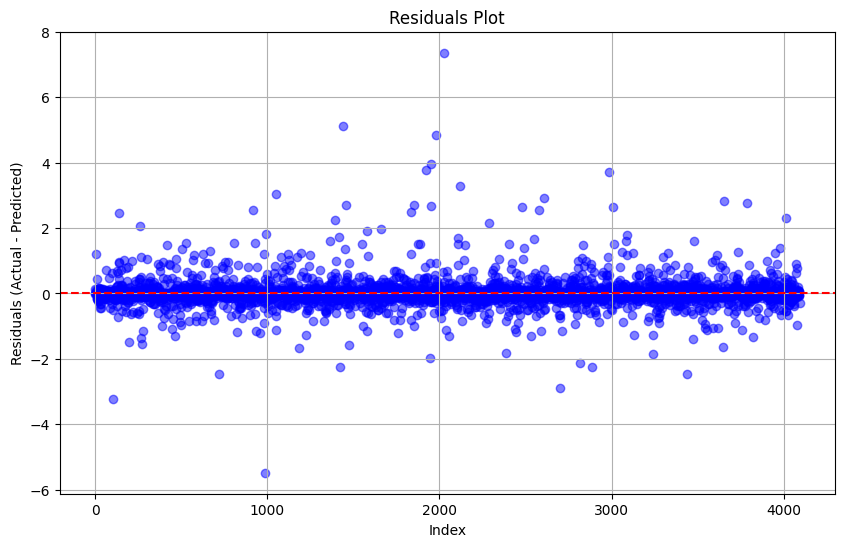

In [21]:
plot_residuals(y_train, pred_train_rf)

From the plot, it seems that the model produced good predictions. The residuals are scattered randomly, and close towards the horizontal line y = 0, which means the errors are mostly small and close to 0

Let's check the MSE and $R^2$

In [22]:
mean_squared_error(pred_train_rf, y_train, squared=False)

0.42389758056365495

In [23]:
r2_score(y_train, pred_train_rf)

0.9955779447755507

The MSE is very close to 0, and the $R^2$ very close to perfect. Since this is the training data, there are chances that the model overfitted. However, since it is a random forest model, it probably didn't overfit too much. We can check with our test data.

In [24]:
pred_test_rf = model_rf.predict(X_test)

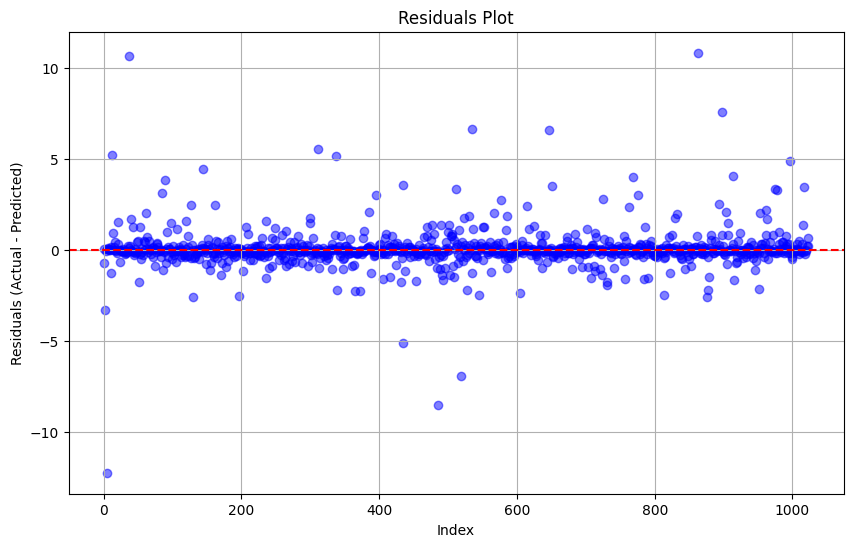

In [25]:
plot_residuals(y_test, pred_test_rf)

In [26]:
mean_squared_error(pred_test_rf, y_test, squared=False)

1.1380673057349515

In [27]:
r2_score(y_test, pred_test_rf)

0.9704193067859317

So it is actually not bad with the test data performance, though slightly worse than performance with training data, but is still acceptable.

Let's see if doing a GridSearch of hyperparameters can potentially improve the model performance.

In [120]:
param_grid = {
    'n_estimators': [50, 100, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'max_depth': [None, 20, 40],  # Maximum number of levels in tree
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
}

This will take some time to run. I suggest don't rerun it, as it is not critical to the final result.

In [121]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 1.2731058203124994


In [122]:
r2_score(y_test, predictions)

0.9709238462519937

So even with hyperparameters, the model performance did not change much. We might as well just stick with the default model.

We can now try estimating for the rows that had missing values in their 'ESTIMATE' column

# Estimate for missing data

In [28]:
future_pred = model_rf.predict(future_data.drop('ESTIMATE', axis = 1))

In [29]:
missing_estimate = drug[drug[target].isna()]

In [30]:
missing_estimate['ESTIMATE'] = future_pred

<ipython-input-30-2688df93e4f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missint_estimate['ESTIMATE'] = future_pred


In [31]:
# look at the result
missing_estimate

,INDICATOR,PANEL,PANEL_NUM,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,YEAR_NUM,AGE,AGE_NUM,ESTIMATE,FLAG
1104,Drug overdose death rates,Drug overdose deaths involving any opioid,1,"Deaths per 100,000 resident population, age-ad...",1,Sex and race,4,Male: Asian or Pacific Islander,4.40,1999,1,All ages,1.10,0.547,*
1184,Drug overdose death rates,Drug overdose deaths involving any opioid,1,"Deaths per 100,000 resident population, age-ad...",1,Sex and race,4,Female: Asian or Pacific Islander,4.80,1999,1,All ages,1.10,0.963,*
1185,Drug overdose death rates,Drug overdose deaths involving any opioid,1,"Deaths per 100,000 resident population, age-ad...",1,Sex and race,4,Female: Asian or Pacific Islander,4.80,2000,2,All ages,1.10,0.993,*
1186,Drug overdose death rates,Drug overdose deaths involving any opioid,1,"Deaths per 100,000 resident population, age-ad...",1,Sex and race,4,Female: Asian or Pacific Islander,4.80,2001,3,All ages,1.10,1.092,*
1187,Drug overdose death rates,Drug overdose deaths involving any opioid,1,"Deaths per 100,000 resident population, age-ad...",1,Sex and race,4,Female: Asian or Pacific Islander,4.80,2002,4,All ages,1.10,1.146,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6217,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: 75-84 years,3.18,2018,20,75-84 years,1.90,1.003,*
6218,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Male: 85 years and over,3.19,2018,20,85 years and over,1.91,0.967,*
6219,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: Under 15 years,3.21,2018,20,Under 15 years,1.20,0.497,*
6226,Drug overdose death rates,Drug overdose deaths involving heroin,5,"Deaths per 100,000 resident population, crude",2,Sex and age,3,Female: 75-84 years,3.28,2018,20,75-84 years,1.90,0.963,*


Since the data is sparse, each year range may not have much data points, so I am defining a method that put rows into year ranges.

In [ ]:
def assign_year_range(year):
    if year < 2002:
        return 'before 2002'
    elif year < 2006:
        return '2002-2006'
    elif year < 2010:
        return '2006-2010'
    elif year < 2014:
        return '2010-2014'
    else:
        return 'after 2014'

<ipython-input-38-389a62a66dcd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missint_estimate['YEAR RANGE'] = missint_estimate['YEAR'].apply(assign_year_range)
<ipython-input-38-389a62a66dcd>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missint_estimate['YEAR RANGE'] = pd.Categorical(missint_estimate['YEAR RANGE'], categories=year_range_order, ordered=True)


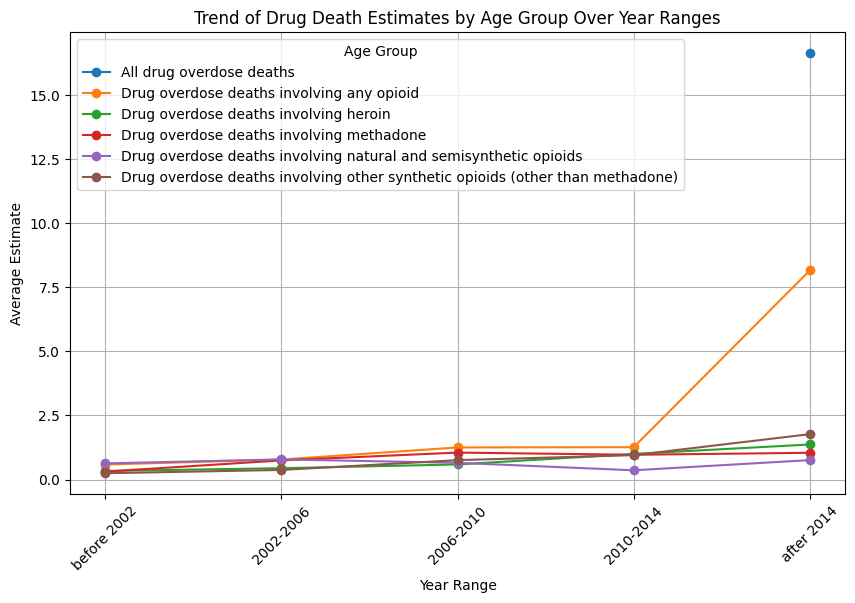

In [38]:
# Apply the function to create a new 'Year Range' column
missing_estimate['YEAR RANGE'] = missing_estimate['YEAR'].apply(assign_year_range)

year_range_order = ['before 2002', '2002-2006', '2006-2010', '2010-2014', 'after 2014']
missing_estimate['YEAR RANGE'] = pd.Categorical(missing_estimate['YEAR RANGE'], categories=year_range_order, ordered=True)

# Pivot the DataFrame
df_pivot = missing_estimate.pivot_table(index='YEAR RANGE', columns='PANEL', values='ESTIMATE', aggfunc='mean')

# Plotting
plt.figure(figsize=(10, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], marker='o', label=column)

plt.title('Trend of Drug Death Estimates by Age Group Over Year Ranges')
plt.xlabel('Year Range')
plt.ylabel('Average Estimate')
plt.legend(title='Age Group')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

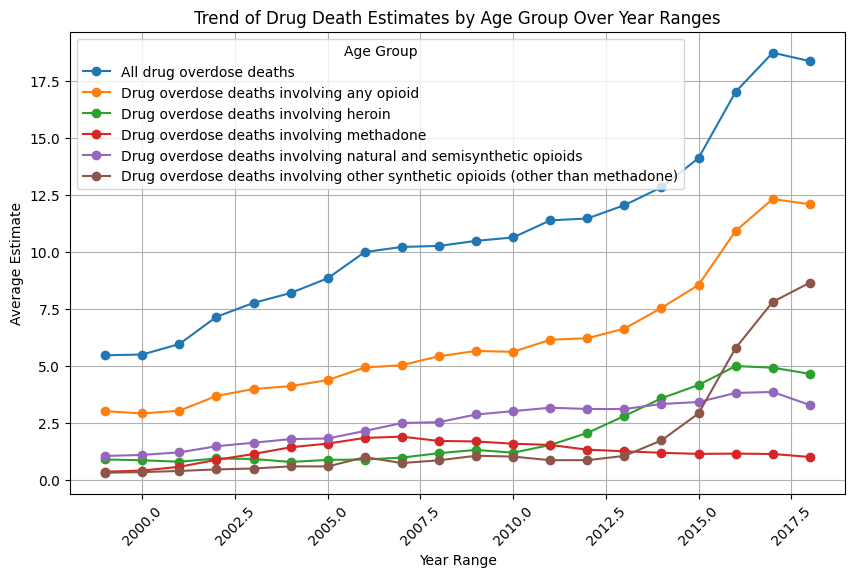

In [40]:
# The entire dataset
df = drug.pivot_table(index='YEAR', columns='PANEL', values='ESTIMATE', aggfunc='mean')

plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], marker='o', label=column)

plt.title('Trend of Drug Death Estimates by Age Group Over Year Ranges')
plt.xlabel('Year Range')
plt.ylabel('Average Estimate')
plt.legend(title='Age Group')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

I think the 'All drug overdose deaths' didn't have too many missing data, so it only have one point for 'after 2014', but we can interpret it as the sum of the rest of the categories.

So from the plotS, we can see the estimated deaths follow a similar trend as the trend given by the rest of the dataset. This gives some evidence that the model is producing valid estimates.

Besides all drug overdose, drug overdose involving any opioid continues to be the most influencial death cause.